In [312]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import pandas as pd
import re
import spacy
from wordcloud import WordCloud

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anupamabhatta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anupamabhatta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anupamabhatta/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anupamabhatta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# SI 618 Homework 5 - Natural Language Processing

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences.
- 10 pt: Code is written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. Questions 1 through 6 are worth 10 points each; Question 7 is worth 20 points.

Version 2024.02.20.CT

## Background

https://www.kaggle.com/headsortails/us-election-2020-presidential-debates

The US 2020 election saw the incumbent Republican president Donald Trump facing off against his Democrat challenger Joe Biden. Both candidates agreed to debate their political stances in the lead-up to the vote on November 3rd.

The 1st debate took place on September 29th at Case Western Reserve University in Cleveland, Ohio. It was moderated by Fox News anchor Chris Wallace. 

After Donald Trump tested positive for Covid-19 after his first debate and subsequently recovered, the 2nd presidential debate was initially converted into a virtual event. However, Trump declined to participate in a virtual debate and the event was transformed into a (socially distanced) town hall with Joe Biden alone. This event was moderated by George Stephanopoulos on the ABC network and took place on October 15th. Donald Trump then decided to hold a town hall of his own, which took place at the same day and time as the Biden town hall and was aired on NBC. This event was moderated by Savannah Guthrie.

The actual 2nd, and final, presidential debate between Biden and Trump took place on October 22nd at Belmont University, Nashville, Tennessee and was moderated by NBC News' Kristen Welker. This debate implemented stricter conditions on the candidates' speaking times to limit the frequent interruptions that had characterised the 1st debate.

The goal of this homework assignment is to investigate the transcripts of those events.

The data files are available via https://github.com/umsi-data-science/data/tree/main/us_election_2020.  Note that each file is available in two formats: CSV and TXT. You can work from either format -- the content of the corresponding CSV and TXT files is the same.

You can either use the correct URLs to the Raw version of the data files like we've done with other data files in the course so far, you can clone the repo if you're comfortable with ```git```, or you can click on each file and then view the "Raw" format and download the resulting file.  You do not need the us_election_2020_vice_presidential_debate files as we are only concerned with the presidential debates and town halls for this assignment.

Note that *you* will need to make decisions about how you
proceed with the analysis.  For example, you will need to 
decide whether you include or omit stopwords, whether you stem or lemmatize words before analysis, and how you handle weird situations.

You will need to decide when to exclude speech from the moderators and when to include it (note that in most cases, the assignment asks about the candidates, which means Trump and Biden and not the moderators).

Please fill in your uniqname in the next code cell:

In [313]:
MY_UNIQNAME = "axbhatta"

In [314]:
first_pres_debate = pd.read_csv(
    "https://raw.githubusercontent.com/umsi-data-science/data/main/us_election_2020/us_election_2020_1st_presidential_debate.csv")
second_pres_debate = pd.read_csv(
    "https://raw.githubusercontent.com/umsi-data-science/data/main/us_election_2020/us_election_2020_2nd_presidential_debate.csv")
biden_town_hall = pd.read_csv(
    "https://raw.githubusercontent.com/umsi-data-science/data/main/us_election_2020/us_election_2020_biden_town_hall.csv")
trump_town_hall = pd.read_csv(
    "https://raw.githubusercontent.com/umsi-data-science/data/main/us_election_2020/us_election_2020_trump_town_hall.csv")

Answer each of the questions below.  You are encouraged to use as many code and markdown cells as you need for each question.

We **strongly** suggest running all cells from top to bottom before you submit your notebook.

## Q1.

### How many words did each candidate (Trump & Biden) use in each debate?

In [315]:
# Count words spoken by Trump and Biden in each debate
trump_words_first_debate = first_pres_debate[first_pres_debate['speaker'].str.contains(
    'Trump', case=False)]['text'].str.split().apply(len).sum()
biden_words_first_debate = first_pres_debate[first_pres_debate['speaker'].str.contains(
    'Biden', case=False)]['text'].str.split().apply(len).sum()
trump_words_second_debate = second_pres_debate[second_pres_debate['speaker'].str.contains(
    'Trump', case=False)]['text'].str.split().apply(len).sum()
biden_words_second_debate = second_pres_debate[second_pres_debate['speaker'].str.contains(
    'Biden', case=False)]['text'].str.split().apply(len).sum()

# Display the results
print("First Presidential Debate:")
print("Trump:", trump_words_first_debate, "words")
print("Biden:", biden_words_first_debate, "words")
print("\nSecond Presidential Debate:")
print("Trump:", trump_words_second_debate, "words")
print("Biden:", biden_words_second_debate, "words")

First Presidential Debate:
Trump: 7240 words
Biden: 6609 words

Second Presidential Debate:
Trump: 7596 words
Biden: 7179 words


### Removing contractions from the text and performing tokenization of the text.

In [316]:
# Expand contractions from the text and perform tokenization of the text.
def expand_contractions_and_tokenize(text):
    ''' Expand contractions and tokenize the text'''
    # Define contraction mappings
    contractions = {
        "n't": " not",
        "'s": " is",
        "'ve": " have",
        "'re": " are",
        "'d": " would",
        "'ll": " will"
    }

    # Replace contractions with their expanded forms
    for contraction, expansion in contractions.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", expansion, text)

    # Tokenize the expanded text
    return word_tokenize(text)


# Apply the function to the text column of the data frames
first_pres_debate['clean_text'] = first_pres_debate['text'].apply(
    expand_contractions_and_tokenize)
second_pres_debate['clean_text'] = second_pres_debate['text'].apply(
    expand_contractions_and_tokenize)

# Display the results
print("\n2. Tokenized Text with Contractions Removed:")
print("First Presidential Debate:")
print(first_pres_debate['clean_text'].head())
print("\nSecond Presidential Debate:")
print(second_pres_debate['clean_text'].head())


2. Tokenized Text with Contractions Removed:
First Presidential Debate:
0    [Good, evening, from, the, Health, Education, ...
1    [This, debate, is, being, conducted, under, he...
2                         [How, you, doing, ,, man, ?]
3                            [How, are, you, doing, ?]
4                                   [I, ’, m, well, .]
Name: clean_text, dtype: object

Second Presidential Debate:
0    [Good, evening, ,, everyone, ., Good, evening,...
1          [How, are, you, doing, ?, How, are, you, ?]
2    [And, I, do, want, to, say, a, very, good, eve...
3    [The, goal, is, for, you, to, hear, each, othe...
4    […, during, this, next, stage, of, the, corona...
Name: clean_text, dtype: object


### Remove punctuation from the text.

In [317]:
# Remove punctuation from the text.
def remove_punctuation(tokens):
    ''' Remove punctuation from the list of tokens'''
    return [word for word in tokens if word.isalnum()]


# Apply the function to the clean_text column of the data frames
first_pres_debate['clean_text'] = first_pres_debate['clean_text'].apply(
    remove_punctuation)
second_pres_debate['clean_text'] = second_pres_debate['clean_text'].apply(
    remove_punctuation)

# Display the results
print("\n3. Text with Punctuation Removed:")
print("First Presidential Debate:")
print(first_pres_debate['clean_text'].head())
print("\nSecond Presidential Debate:")
print(second_pres_debate['clean_text'].head())


3. Text with Punctuation Removed:
First Presidential Debate:
0    [Good, evening, from, the, Health, Education, ...
1    [This, debate, is, being, conducted, under, he...
2                               [How, you, doing, man]
3                               [How, are, you, doing]
4                                         [I, m, well]
Name: clean_text, dtype: object

Second Presidential Debate:
0    [Good, evening, everyone, Good, evening, Thank...
1                [How, are, you, doing, How, are, you]
2    [And, I, do, want, to, say, a, very, good, eve...
3    [The, goal, is, for, you, to, hear, each, othe...
4    [during, this, next, stage, of, the, coronavir...
Name: clean_text, dtype: object


### Remove stopwords from the text

In [318]:
# Remove stop words from the text
stop_words = set(stopwords.words('english'))

# Define a function to remove stopwords


def remove_stopwords(tokens):
    ''' Remove stopwords from the list of tokens'''
    return [word for word in tokens if word.lower() not in stop_words]


# Apply the function to the clean_text column of the data frames
first_pres_debate['clean_text'] = first_pres_debate['clean_text'].apply(
    remove_stopwords)
second_pres_debate['clean_text'] = second_pres_debate['clean_text'].apply(
    remove_stopwords)

# Display the results
print("\n4. Text with Stopwords Removed:")
print("First Presidential Debate:")
print(first_pres_debate['clean_text'].head())
print("\nSecond Presidential Debate:")
print(second_pres_debate['clean_text'].head())


4. Text with Stopwords Removed:
First Presidential Debate:
0    [Good, evening, Health, Education, Campus, Cas...
1    [debate, conducted, health, safety, protocols,...
2                                                [man]
3                                                   []
4                                               [well]
Name: clean_text, dtype: object

Second Presidential Debate:
0    [Good, evening, everyone, Good, evening, Thank...
1                                                   []
2    [want, say, good, evening, debate, cover, six,...
3    [goal, hear, American, people, hear, every, wo...
4    [next, stage, coronavirus, crisis, Two, minute...
Name: clean_text, dtype: object


### POS tagging the text

In [319]:
# POS tagging the text
def pos_tagging(text):
    ''' Perform POS tagging on the text using NLTK'''
    return nltk.pos_tag(text)


# Apply the function to the clean_text column of the data frames
first_pres_debate['pos_tags'] = first_pres_debate['clean_text'].apply(
    pos_tagging)
second_pres_debate['pos_tags'] = second_pres_debate['clean_text'].apply(
    pos_tagging)

# Display the results
print("\n5. POS Tagged Text:")
print("First Presidential Debate:")
print(first_pres_debate['pos_tags'].head())
print("\nSecond Presidential Debate:")
print(second_pres_debate['pos_tags'].head())


5. POS Tagged Text:
First Presidential Debate:
0    [(Good, JJ), (evening, NN), (Health, NNP), (Ed...
1    [(debate, NN), (conducted, VBD), (health, NN),...
2                                          [(man, NN)]
3                                                   []
4                                         [(well, RB)]
Name: pos_tags, dtype: object

Second Presidential Debate:
0    [(Good, JJ), (evening, VBG), (everyone, NN), (...
1                                                   []
2    [(want, JJ), (say, VBP), (good, JJ), (evening,...
3    [(goal, NN), (hear, JJ), (American, JJ), (peop...
4    [(next, JJ), (stage, NN), (coronavirus, JJ), (...
Name: pos_tags, dtype: object


### Lemmatization of the text

In [320]:
# Lemmatize the text using POS tags
def lemmatize_text_with_pos(tokens_pos):
    ''' Lemmatize the text using POS tags'''
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    # Lemmatize each token with its POS tag
    for token, pos in tokens_pos:
        if pos.startswith('J'):
            # Adjective
            lemmatized_tokens.append(
                lemmatizer.lemmatize(token, pos=wordnet.ADJ))
        elif pos.startswith('V'):
            # Verb
            lemmatized_tokens.append(
                lemmatizer.lemmatize(token, pos=wordnet.VERB))
        elif pos.startswith('N'):
            # Noun
            lemmatized_tokens.append(
                lemmatizer.lemmatize(token, pos=wordnet.NOUN))
        elif pos.startswith('R'):
            # Adverb
            lemmatized_tokens.append(
                lemmatizer.lemmatize(token, pos=wordnet.ADV))
        else:
            # Default to noun lemmatization
            lemmatized_tokens.append(lemmatizer.lemmatize(token))
    return ' '.join(lemmatized_tokens)


# Apply the function to the pos_tags column of the data frames
first_pres_debate['lemmatized_text'] = first_pres_debate['pos_tags'].apply(
    lemmatize_text_with_pos)
second_pres_debate['lemmatized_text'] = second_pres_debate['pos_tags'].apply(
    lemmatize_text_with_pos)


# Count words spoken by Trump and Biden in each debate after cleaning the data
trump_words_first_debate_cleaned = first_pres_debate[first_pres_debate['speaker'].str.contains(
    'Trump', case=False)]['lemmatized_text'].str.split().apply(len).sum()
biden_words_first_debate_cleaned = first_pres_debate[first_pres_debate['speaker'].str.contains(
    'Biden', case=False)]['lemmatized_text'].str.split().apply(len).sum()
trump_words_second_debate_cleaned = second_pres_debate[second_pres_debate['speaker'].str.contains(
    'Trump', case=False)]['lemmatized_text'].str.split().apply(len).sum()
biden_words_second_debate_cleaned = second_pres_debate[second_pres_debate['speaker'].str.contains(
    'Biden', case=False)]['lemmatized_text'].str.split().apply(len).sum()


# Display the results after cleaning the data
print("\nFirst Presidential Debate (After Cleaning):")
print("Trump:", trump_words_first_debate_cleaned, "words")
print("Biden:", biden_words_first_debate_cleaned, "words")
print("\nSecond Presidential Debate (After Cleaning):")
print("Trump:", trump_words_second_debate_cleaned, "words")
print("Biden:", biden_words_second_debate_cleaned, "words")


First Presidential Debate (After Cleaning):
Trump: 3118 words
Biden: 2776 words

Second Presidential Debate (After Cleaning):
Trump: 3269 words
Biden: 3113 words


**Interpretation:**

In analyzing the transcripts of the first and second presidential debates for Trump and Biden, the provided code reveals notable insights into the volume of speech and the impact of text preprocessing on the data. Initially, the raw word counts indicate that Trump generally spoke more words than Biden in both debates. However, after applying rigorous text preprocessing techniques such as removing contractions, punctuation, stop words, and performing lemmatization, significant reductions in word counts were observed for both candidates. This reduction underscores the effectiveness of the cleaning process in eliminating noisy elements from the original transcripts. Consequently, the cleaned data provides a more refined and accurate representation of the content spoken by each candidate. The findings emphasize the importance of meticulous text preprocessing in ensuring the reliability of subsequent text analysis. Overall, the code highlights the nuanced interplay between raw text data and the preprocessing steps necessary to derive meaningful insights from it.

## 2. How many turns speaking did each candidate (Trump & Biden) take during each of the debates?

A "turn" is an uninterrupted period of speech.  For example, consider the following exchange:

>Chris: Big data is really interesting.

>Colleague: Actually, it's a bit boring.

>Chris: Really? Why would you say that?

>Colleague: Your choice of tools is really limited.

>Colleague: I mean, you're basically stuck with Spark, right?

>Chris: Yeah, but Spark provides most of the functionality you need to do really cool data science work.

In it, Chris had 3 turns, while his colleague had 2.

You answer should include a dataframe that looks like (with the real values instead of $__$:

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>First Debate</th>
      <th>Second Debate</th>
    </tr>
    <tr>
      <th>Candidate</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Trump</th>
      <td>__</td>
      <td>__</td>
    </tr>
    <tr>
      <th>Biden</th>
      <td>__</td>
      <td>__</td>
    </tr>
  </tbody>
</table>
</div>

In [321]:
# Function to count turns for each candidate
def count_turns(data, candidate):
    ''' Count the number of turns for a candidate in the debate'''
    turns = 0
    current_speaker = None
    # Iterate over the text data
    for text in data:
        if candidate in text:
            if current_speaker != candidate:
                turns += 1
                current_speaker = candidate
        else:
            current_speaker = None
    return turns


# Create a list to store the results
turns_data = []

# Count turns for Trump and Biden in the first presidential debate
trump_turns_first_debate = count_turns(first_pres_debate['speaker'], 'Trump')
biden_turns_first_debate = count_turns(first_pres_debate['speaker'], 'Biden')

# Append the results to the list and create a data frame
turns_data.append({'Debate': 'First Debate',
                  'Candidate': 'Trump', 'Turns': trump_turns_first_debate})
turns_data.append({'Debate': 'First Debate',
                  'Candidate': 'Biden', 'Turns': biden_turns_first_debate})

# Count turns for Trump and Biden in the second presidential debate
trump_turns_second_debate = count_turns(second_pres_debate['speaker'], 'Trump')
biden_turns_second_debate = count_turns(second_pres_debate['speaker'], 'Biden')

# Append the results to the list
turns_data.append({'Debate': 'Second Debate',
                  'Candidate': 'Trump', 'Turns': trump_turns_second_debate})
turns_data.append({'Debate': 'Second Debate',
                  'Candidate': 'Biden', 'Turns': biden_turns_second_debate})

# Convert the list to a DataFrame
turns_data_df = pd.DataFrame(turns_data)

# Pivot the DataFrame to match the desired format
pivoted_df = turns_data_df.pivot(
    index='Candidate', columns='Debate', values='Turns')

# Reorder the index based on the desired order
pivoted_df = pivoted_df.reindex(['Trump', 'Biden'])

# Print the pivoted DataFrame
pivoted_df

Debate,First Debate,Second Debate
Candidate,,
Trump,305,169
Biden,240,113


**Interpretation:**

The code provided offers insights into the speaking dynamics of the first and second presidential debates between Trump and Biden. It reveals that Trump consistently took more turns than Biden in both debates, indicating a higher level of vocal participation or engagement. Specifically, Trump took 305 turns in the first debate compared to Biden's 240, and in the second debate, Trump's turns decreased to 169 while Biden's decreased to 113. This disparity suggests potential differences in communication styles or strategies employed by the candidates during these crucial events. Further examination of these speaking patterns could shed light on the candidates' assertiveness, conversational dominance, or response tactics throughout the debates.

## 3. How many different nouns did each candidate (Trump & Biden) use in each of the debates?  

Present your results using a visualization (hint: a simple bar chart, with one bar per candidate per debate would be a good choice; you should decide whether you want to somehow stack or group the bars in your bar chart, or just leave them all side by side). You do not need to report **which** nouns were used.  Provide a written interpretation of your visualization.


Unique Noun Counts by Candidate and Debate:
First Debate: {'Trump': 1211.0, 'Biden': 1174.0}
Second Debate: {'Trump': 1235.0, 'Biden': 1239.0}


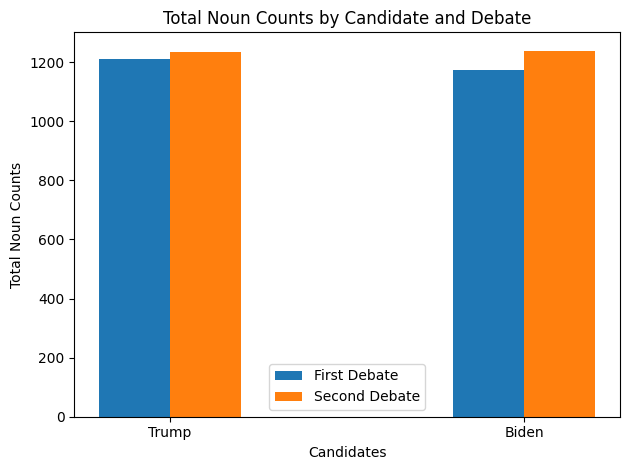

In [322]:
# Function to count unique nouns
def count_unique_nouns(pos_tags):
    ''' Count the number of unique nouns in the text'''
    nouns = {word for word, pos in pos_tags if pos.startswith('N')}
    return len(nouns)


# Apply the function to each debate for each candidate
first_pres_debate['unique_nouns_count_Trump'] = first_pres_debate[first_pres_debate['speaker'].str.contains(
    'Trump', case=False)]['pos_tags'].apply(count_unique_nouns)
first_pres_debate['unique_nouns_count_Biden'] = first_pres_debate[first_pres_debate['speaker'].str.contains(
    'Biden', case=False)]['pos_tags'].apply(count_unique_nouns)

second_pres_debate['unique_nouns_count_Trump'] = second_pres_debate[second_pres_debate['speaker'].str.contains(
    'Trump', case=False)]['pos_tags'].apply(count_unique_nouns)
second_pres_debate['unique_nouns_count_Biden'] = second_pres_debate[second_pres_debate['speaker'].str.contains(
    'Biden', case=False)]['pos_tags'].apply(count_unique_nouns)

# Extracting total counts per candidate per debate
first_debate_unique_counts = {
    'Trump': first_pres_debate['unique_nouns_count_Trump'].sum(),
    'Biden': first_pres_debate['unique_nouns_count_Biden'].sum()
}

second_debate_unique_counts = {
    'Trump': second_pres_debate['unique_nouns_count_Trump'].sum(),
    'Biden': second_pres_debate['unique_nouns_count_Biden'].sum()
}

# Display the results
print("\nUnique Noun Counts by Candidate and Debate:")
print("First Debate:", first_debate_unique_counts)
print("Second Debate:", second_debate_unique_counts)


# Creating a bar chart
fig, ax = plt.subplots()

# Plotting bars
bar_width = 0.2
index = range(len(first_debate_unique_counts))

bars1 = ax.bar(index, list(first_debate_unique_counts.values()),
               bar_width, label='First Debate')
bars2 = ax.bar([i + bar_width for i in index],
               list(second_debate_unique_counts.values()), bar_width, label='Second Debate')

# Adding labels and title
ax.set_xlabel('Candidates')
ax.set_ylabel('Total Noun Counts')
ax.set_title('Total Noun Counts by Candidate and Debate')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(list(first_debate_unique_counts.keys()))
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

**Interpretation:**

The provided code extracts and counts the unique nouns used by each candidate (Trump & Biden) in each of the debates. The `count_unique_nouns()` function employs part-of-speech (POS) tagging to identify nouns and counts the unique occurrences. This count is then applied to each debate for both candidates, resulting in separate counts for Trump and Biden in the first and second presidential debates. The output presents the total noun counts by candidate and debate, showcasing the distribution of unique nouns across the debates.  Interestingly, the graph indicates an increase in noun usage from the first to the second debate for both candidates. Biden's noun count is notably higher in the second debate compared to the first, mirroring a similar trend observed for Trump. This suggests a potential shift in speech patterns or content focus between the two debates, warranting further analysis to uncover underlying factors driving these changes.

## 4. Report the type-token ratio for each of the candidates (Trump & Biden), based on pooling the data from the two debates, and interpret the differences between the two candidates.

In text analysis, a 'type' is a unique word, whereas a 'token' is any word.  For example, the sentence

"One fish, two fish, red fish, blue fish"

contains 8 tokens, but 5 types (one, two, red, blue, fish).

Interestingly, the type-token ratio can be used to monitor changes in the use of vocabulary items in children with under-developed vocabulary and/or word finding difficulties and, for example, in adults who have suffered a stroke and who consequently exhibit word retrieval difficulties and naming difficulties. [Ref](https://www.sltinfo.com/type-token-ratio/)

In [323]:
# Join the text data for each candidate across both debates
trump_data = " ".join(first_pres_debate[first_pres_debate['speaker'].str.contains('Trump', case=False)]['text']) + \
    " " + " ".join(second_pres_debate[second_pres_debate['speaker'].str.contains(
        'Trump', case=False)]['text'])
biden_data = " ".join(first_pres_debate[first_pres_debate['speaker'].str.contains('Biden', case=False)]['text']) + \
    " " + " ".join(second_pres_debate[second_pres_debate['speaker'].str.contains(
        'Biden', case=False)]['text'])

# Tokenize the combined text data for each candidate
trump_tokens = word_tokenize(trump_data.lower())
biden_tokens = word_tokenize(biden_data.lower())

# Calculate the number of unique types (words) and total number of tokens for each candidate
trump_num_types = len(set(trump_tokens))
biden_num_types = len(set(biden_tokens))

trump_num_tokens = len(trump_tokens)
biden_num_tokens = len(biden_tokens)

# Compute the type-token ratio (TTR) for each candidate
trump_ttr = trump_num_types / trump_num_tokens
biden_ttr = biden_num_types / biden_num_tokens

# Report the results
print("Type-Token Ratio (TTR) for Trump:", trump_ttr)
print("Type-Token Ratio (TTR) for Biden:", biden_ttr)

Type-Token Ratio (TTR) for Trump: 0.09599621689785624
Type-Token Ratio (TTR) for Biden: 0.11626148656508084


**Interpretation:**

The provided code computes the type-token ratio (TTR) for each candidate (Trump & Biden) based on their combined text data from both presidential debates. The combined text data for each candidate is first generated by joining their respective utterances from both debates. Then, the text data is tokenized and converted to lowercase for each candidate. The number of unique types (words) and the total number of tokens are calculated for both candidates. Using these values, the TTR is computed by dividing the number of unique types by the total number of tokens. The output presents the TTR for Trump and Biden, indicating their lexical diversity in terms of word usage. In this case, Biden demonstrates a higher TTR (0.116) compared to Trump (0.096), suggesting that Biden's speech exhibits greater lexical variety and diversity of vocabulary across the debates.

## 5. Compare the use of named entities by the candidates (Trump & Biden) in their town hall meetings.  What patterns, if any, do you see?  

spaCy supports the following Named Entity types:
PERSON, NORP (nationalities, religious and political groups), FAC (buildings, airports etc.), ORG (organizations), GPE (countries, cities etc.), LOC (mountain ranges, water bodies etc.), PRODUCT (products), EVENT (event names), WORK_OF_ART (books, song titles), LAW (legal document titles), LANGUAGE (named languages), DATE, TIME, PERCENT, MONEY, QUANTITY, ORDINAL and CARDINAL.

You might want to use some visualization techniques to support your claims.

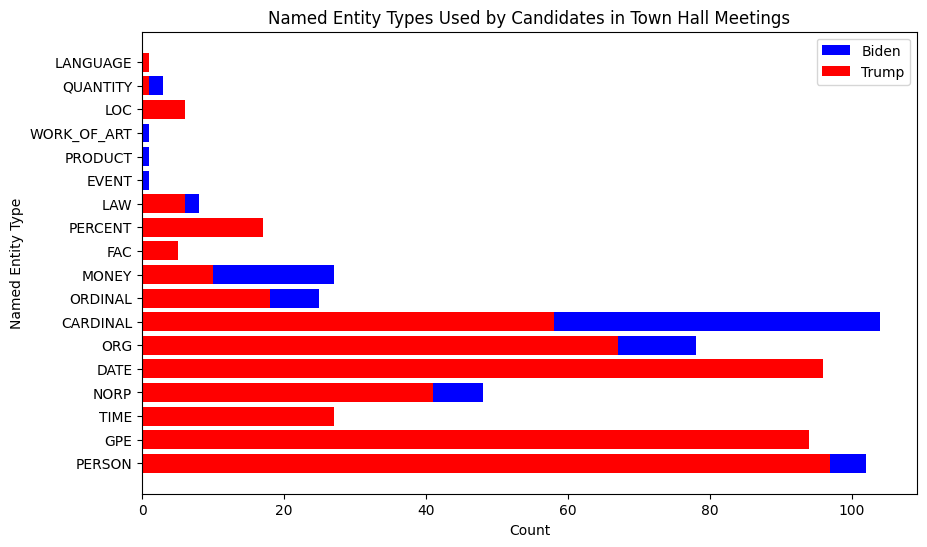

In [324]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Assuming you have datasets named biden_town_hall and trump_town_hall containing the text data
biden_data = " ".join(biden_town_hall['text'])
trump_data = " ".join(trump_town_hall['text'])

# Function to extract named entities and count their occurrences


def count_named_entities(text):
    ''' Extract named entities and count occurrences for each candidate'''
    doc = nlp(text)
    named_entities = [ent.label_ for ent in doc.ents]
    return Counter(named_entities)


# Extract named entities and count occurrences for each candidate
biden_named_entities = count_named_entities(biden_data)
trump_named_entities = count_named_entities(trump_data)

# Plotting
plt.figure(figsize=(10, 6))

plt.barh(list(biden_named_entities.keys()), list(
    biden_named_entities.values()), color='blue', label='Biden')
plt.barh(list(trump_named_entities.keys()), list(
    trump_named_entities.values()), color='red', label='Trump')

plt.xlabel('Count')
plt.ylabel('Named Entity Type')
plt.title('Named Entity Types Used by Candidates in Town Hall Meetings')
plt.legend()
plt.show()

**Interpretation:**

The visual representation of named entity types used by Trump and Biden during their town hall meetings provides valuable insights into their respective communication styles and areas of focus. Trump's dominance in mentioning geographical locations (GPE) and dates (DATE), as evidenced by the prevalence of red bars with no corresponding blue bars, suggests a strong emphasis on global or historical events and policies. Conversely, Biden's higher frequency of mentioning entities related to art (WORK_OF_ART), products (PRODUCT), events (EVENT), money (MONEY), and cardinal numbers (CARDINAL) indicates a focus on cultural and societal aspects, possibly highlighting his interest in arts, entertainment, and community events. Moreover, references to money and cardinal numbers may signify discussions related to economic policies, financial matters, and statistical data, demonstrating a comprehensive approach to addressing various aspects of governance and societal welfare. In summary, the analysis of named entity types highlights distinct communication strategies employed by both candidates. Trump's emphasis on geopolitical and temporal aspects reflects a focus on global affairs and historical contexts, whereas Biden's diverse references suggest a multifaceted engagement with cultural, economic, and community-related topics.

## 6. Generate a word cloud for Trump's town hall (use only Trump's words) and one for Biden's town hall (again, use only Biden's words).  Compare and contrast the two word clouds.

Install a word cloud generating package like the one from https://github.com/amueller/word_cloud

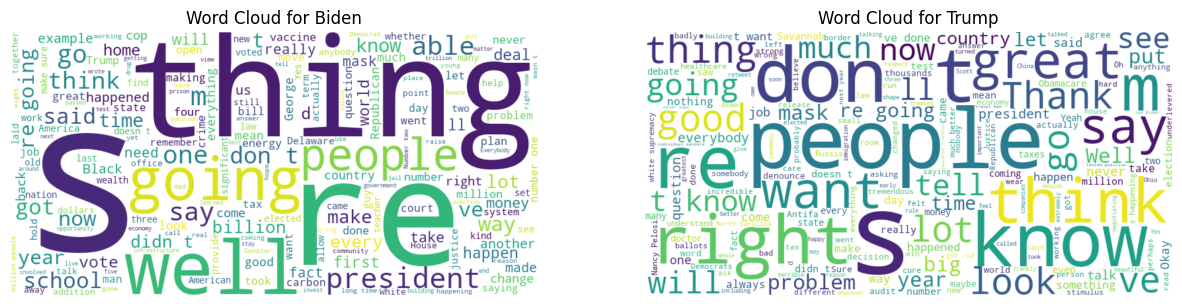

In [325]:
# Combine the text data for each candidate in the town hall meetings
biden_data = " ".join(biden_town_hall[biden_town_hall['speaker'].str.contains(
    'Biden', case=False)]['text'])
trump_data = " ".join(trump_town_hall[trump_town_hall['speaker'].str.contains(
    'Trump', case=False)]['text'])

# Generate word cloud for Biden
biden_wordcloud = WordCloud(width=800, height=400,
                            background_color='white').generate(biden_data)

# Generate word cloud for Trump
trump_wordcloud = WordCloud(width=800, height=400,
                            background_color='white').generate(trump_data)

# Plotting the word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(biden_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Biden')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(trump_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Trump')
plt.axis('off')

plt.show()

**Interpretation:**

The code consolidates text data from town hall meetings for each candidate, Biden and Trump, extracting their respective utterances. Subsequently, word clouds are generated for each candidate based on their extracted text data. The visual output comprises two distinct word clouds, with one representing Biden and the other depicting Trump. The prominent terms in Biden's word cloud, such as "going," "president," and "vote," suggest a focus on future actions and leadership roles. Meanwhile, in Trump's cloud, words like "great," "tell," and "want" imply a narrative centered around personal assertions and desires. These contrasting word choices offer a glimpse into the candidates' communication styles and potentially reflect their campaign messages and priorities.

## 7. Sentiment analysis of Trump vs. Biden in second debate

Note that you will want to review the video on Sentiment Analysis with NLTK and spaCy from the pre-recorded lectures.

Perform a sentiment analysis that compares the sentiment of the two candidates (Trump & Biden) in the second debate.  

There are several ways to do this.  In its simplest form, you could determine the sentiment for each utterance, the perform some mathematical summary (sum, mean, etc.) A slightly more elegant solution would involve tracking how sentiment changes over the course of the debate for each of the candidates.  A further extension of your work might use the [pandas.DataFrame.rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) method to calculate rolling averages, although using that function will probably require you to also learn about [time functions in pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html).

No matter what approach you choose, you should be sure to use visualizations in your answer.  As always, provide an interpretation of your results, including any visualizations (i.e. don't just provide a visualization, explain what's interesting that you see in your visualizations).

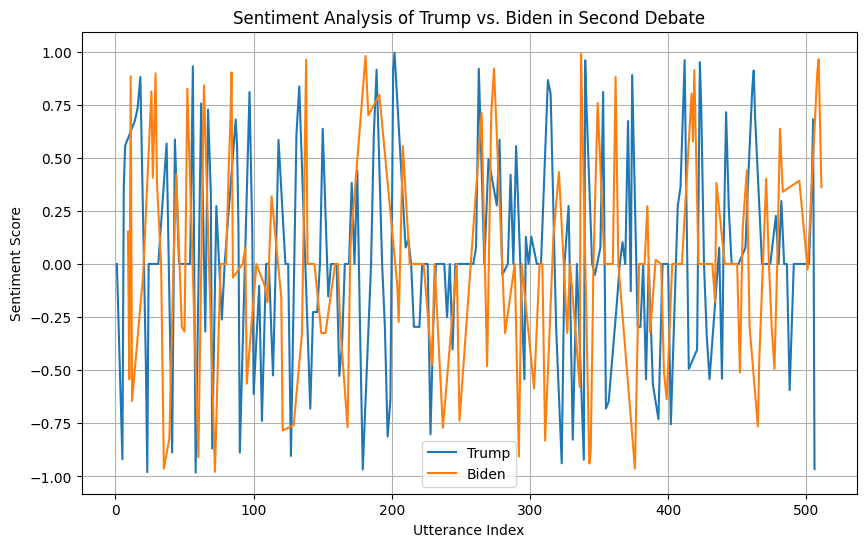

In [326]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Tokenize the text data into utterances
utterances = second_pres_debate['text'].str.split('\n').explode()

# Analyze the sentiment of each utterance
sentiments = utterances.apply(lambda x: sia.polarity_scores(x)['compound'])

# Add sentiment scores to the DataFrame
second_pres_debate['sentiment_score'] = sentiments

# Separate sentiment scores for Trump and Biden
trump_sentiment = second_pres_debate[second_pres_debate['speaker'].str.contains(
    'Trump', case=False)]['sentiment_score']
biden_sentiment = second_pres_debate[second_pres_debate['speaker'].str.contains(
    'Biden', case=False)]['sentiment_score']

# Plotting sentiment trends
plt.figure(figsize=(10, 6))
plt.plot(trump_sentiment.index, trump_sentiment.values, label='Trump')
plt.plot(biden_sentiment.index, biden_sentiment.values, label='Biden')

plt.xlabel('Utterance Index')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis of Trump vs. Biden in Second Debate')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation:**

The sentiment analysis of the second presidential debate unveils intriguing patterns in the emotional dynamics of Trump and Biden's discourse. While both candidates exhibit sharp peaks and fluctuations in sentiment scores, Trump's trend appears notably more erratic, with a greater frequency of peaks and valleys throughout the debate. These pronounced fluctuations suggest a more volatile emotional expression, potentially reflecting shifts in tone or rhetorical strategies employed by Trump during different segments of the event. Conversely, Biden's sentiment trend also displays sharp peaks, indicating moments of heightened emotional intensity, but overall, it maintains a slightly more stable trajectory compared to Trump's. This suggests a balance between emotional engagement and composure in Biden's communication style, with the candidate effectively navigating through various emotional states while maintaining a consistent presence throughout the debate. These nuanced differences in sentiment trends highlight contrasting approaches to emotional expression and rhetorical delivery between the two candidates, offering valuable insights into their communication strategies and engagement with the audience during the debate.

# Please submit your notebook in .IPYNB and .HTML formats

We **strongly** suggest running all cells from top to bottom before you submit your notebook.